# Feature engineering for Machine Learning

## Predicting absenteeism
A large problem within organisations is how to motivate their employees. In this blog, we will use [HappyForce](https://www.kaggle.com/harriken/predict-employee-ausentism) in order to predict employment absenteeism. The goal is to identify who are likely to be abscent in the near future, and find the reasons for absenteeism.  

This blog is the first part and contains Feature engineering and EDA for machine learning. Part 2 contains the machine learning part where we build models and compare the results. This blog shows various ways in which feature engineering can be carried out on time series datasets.     

We focused on data from 408 employees of one company in Spain; 62 have record of absence. The below chart summarizes the main reasons for leave; in our case, common sickness / non job-related accidents are the main reasons. Given we are to analyse employee absence as it relates to motivation, it is feasible to assume a portion of these employees simply call in sick as they lack motivation or commitment to their workplace.  

## Employee absenteeism dataset
The datasets contains 7 files, first let us look at the **employeeAbsenteeism** dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
df = pd.read_csv('employeeAbsenteeism.csv')
df.to = pd.to_datetime(df.to) # converts string to type datetime
df['from'] = pd.to_datetime(df['from'])
df

,employee,companyAlias,from,to,reason
0,19Q,C1,2018-10-01 00:10:00,2018-10-26 00:10:00,Workplace accident
1,NY3,C1,2018-10-01 00:10:00,2018-10-31 00:10:00,Common sickness or accident not related to th...
2,qKO,C1,2018-10-01 00:10:00,2018-10-05 00:10:00,Common sickness or accident not related to th...
3,qKO,C1,2018-10-10 00:10:00,2018-10-31 00:10:00,Common sickness or accident not related to th...
4,2wx,C1,2018-10-01 00:10:00,2018-10-31 00:10:00,Common sickness or accident not related to th...
...,...,...,...,...,...
101,JD1,C1,2018-06-19 00:06:00,2018-06-22 00:06:00,Common sickness or accident not related to th...
102,3WW,C1,2018-06-20 00:06:00,2018-06-21 00:06:00,Common sickness or accident not related to th...
103,2ER,C1,2018-06-01 00:06:00,2018-06-30 00:06:00,Common sickness or accident not related to th...
104,ONv,C1,2018-06-08 00:06:00,2018-06-08 00:06:00,Common sickness or accident not related to th...


We can see that the dataset contains details of leaves taken by employees, the from-date, to-date, the leave time, and the reason for leave given by the employee.  

In [3]:
df.describe(include='all', datetime_is_numeric=True)

,employee,companyAlias,from,to,reason
count,106,106,106,106,106
unique,62,1,NaN,NaN,4
top,yKX,C1,NaN,NaN,Common sickness or accident not related to th...
freq,4,106,NaN,NaN,96
mean,NaN,NaN,2018-08-11 04:12:33.962264320,2018-08-26 23:13:41.886792448,NaN
min,NaN,NaN,2018-06-01 00:06:00,2018-06-06 00:06:00,NaN
25%,NaN,NaN,2018-06-18 06:06:00,2018-06-30 00:06:00,NaN
50%,NaN,NaN,2018-08-01 00:08:00,2018-08-31 00:08:00,NaN
75%,NaN,NaN,2018-10-01 00:10:00,2018-10-23 12:10:00,NaN
max,NaN,NaN,2018-10-31 00:10:00,2018-10-31 00:10:00,NaN


Further we can see that the data is across only one company, across 62 employees taking a total of around 106 leaves (not days of leave) with 4 unique reasons. The maximum period of leaves is 30 days, and the frequency of the leave perod is shown below. The majority of employees take either a short 1-3 days leave, or a much longer 27-30 day leave (likely due to a sickness, accident, or similar issue).

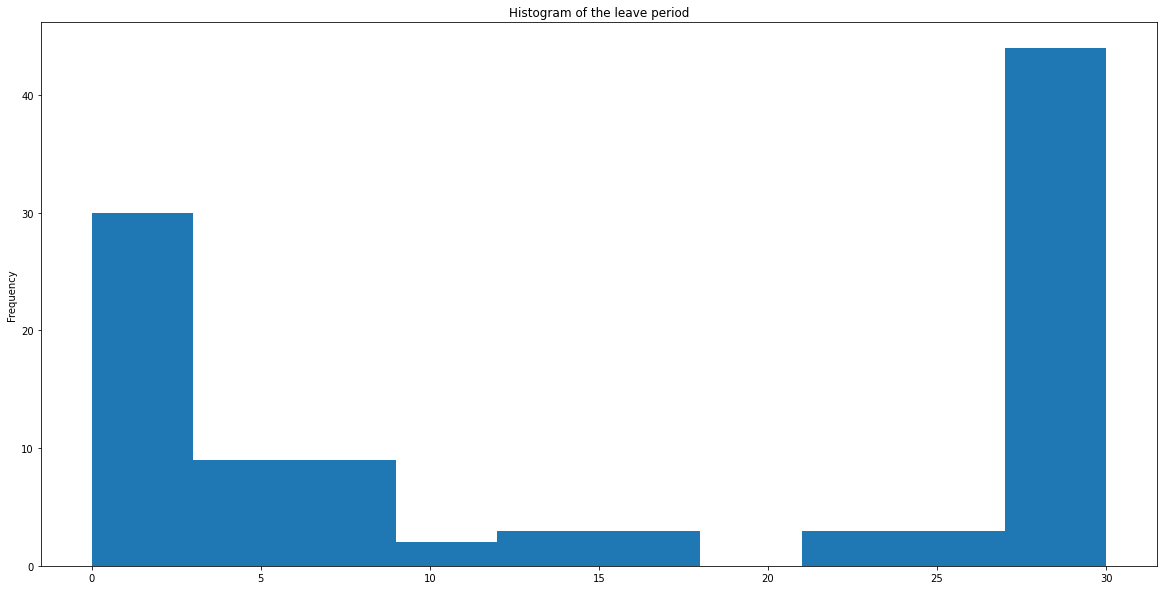

In [4]:
df['leave_time'] = (df['to'] - df['from'])/np.timedelta64(1, 'D') # takes the difference in days
df['date'] = df['from'].dt.date.astype('datetime64[ns]') # gets only the date part from the timeframe

f, ax = plt.subplots(1, figsize = (20,10))
df['leave_time'].plot.hist()
plt.title('Histogram of the leave period')
plt.show()

There are four reasons given for leaves, with "Common sickness not related to the job" as the most common reason. The below pie charts summarize the main reasons for leave shows that the main reasons employees take leave. In our case, common sickness / non job-related accidents are the main reasons for absence.

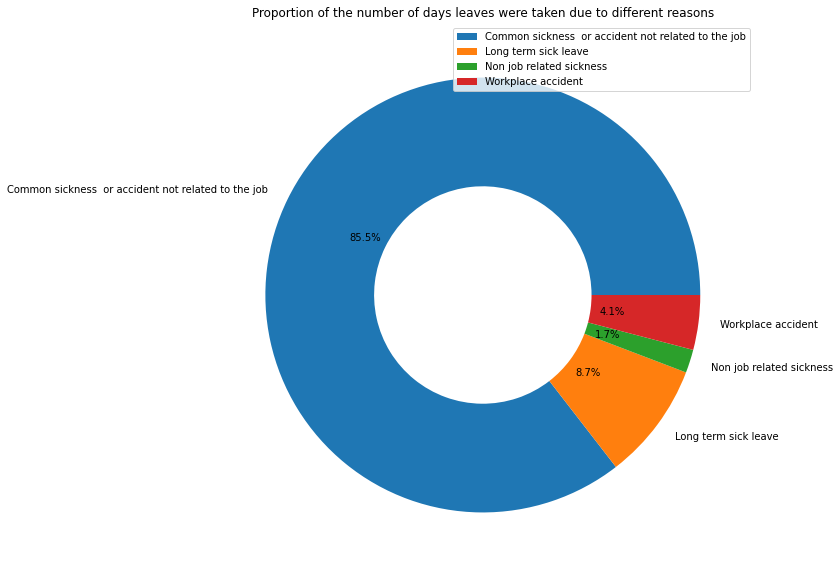

In [5]:
df.groupby('reason').\
    aggregate({'leave_time':'sum'}).\
    plot.pie(y='leave_time', figsize=(10, 10), 
             autopct='%1.1f%%', # to add the percentages text
             wedgeprops=dict(width=.5)
            )
plt.ylabel("")
plt.title('Proportion of the number of days leaves were taken due to different reasons')
plt.show()

Aditionally, we can observe that the most of the leaves were taken from the first of the month, and ended at the end of the month.

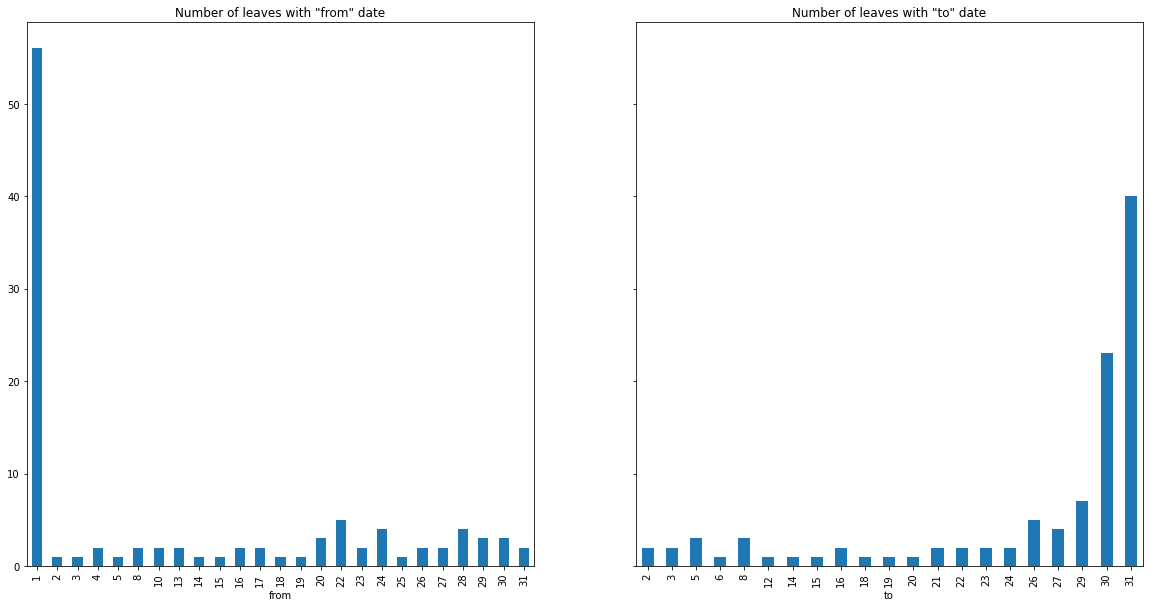

In [6]:
f, ax = plt.subplots(1, 2, figsize = (20,10), sharey = True)
df.groupby(df['from'].dt.day)['employee'].count().\
    plot(kind='bar', ax=ax[0], title = 'Number of leaves with "from" date')
df.groupby(df['to'].dt.day)['employee'].count().\
    plot(kind='bar', ax=ax[1], title = 'Number of leaves with "to" date')
plt.show()

The below scatterplot shows the number fof employees at any date.

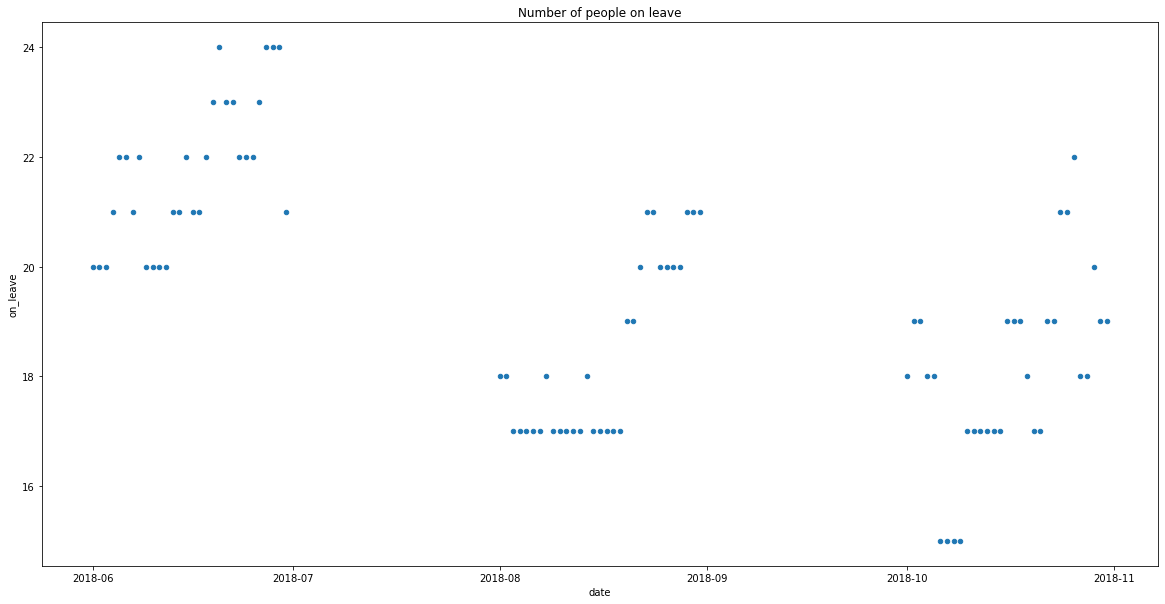

In [7]:
# Feature engineering on absentism dataset
# creating a dataframe with leaves as per employee and dates
leave_df = pd.DataFrame({'date':[], 'employee':[], 'reason':[]})
for index, row in df.iterrows():
    dates = pd.date_range(row['from'].date(), row['to'].date())
    for date in dates:
        leave_df = leave_df.append({'date':date, 'employee':row['employee'], 'reason':row['reason']} ,ignore_index=True)
leave_df['on_leave'] = 1

# Creating a cumulative sum to get tehe number of leaves taken by the employee till date
leave_df['no_leaves_till_date'] = leave_df.groupby('employee')['on_leave'].transform(lambda x: x.cumsum().shift()).fillna(0)

f, ax = plt.subplots(1, figsize = (20,10))
leave_df.groupby(['date'])['on_leave'].sum().reset_index().plot(x = 'date', y = 'on_leave', kind = 'scatter', ax=ax)
plt.title('Number of people on leave')
plt.show()

We can see that most of the leaves are in three months in 2018, indicating that these could be a subset of the data.

## Employee details
The next dataset to look at **lastparticipationExists** which has the last participation date along with the details of the employee. This data also has number of votes each employee has till date (this variable can be used as a proxy for engagement).

In [8]:
employee_details = pd.read_csv("lastParticipationExists.csv")
employee_details.lastParticipationDate = pd.to_datetime(employee_details.lastParticipationDate)
employee_details.deletedOn = pd.to_datetime(employee_details.deletedOn)
employee_details.stillExists = employee_details.stillExists.astype(int)
employee_details

,employee,companyAlias,numVotes,lastParticipationDate,timezone,stillExists,deletedOn
0,l8,C1,285,2019-03-08 01:03:00,Europe/Madrid,1,NaT
1,Xv,C1,143,2018-04-21 02:04:00,Europe/Berlin,1,NaT
2,w7,C1,381,2019-03-11 01:03:00,Europe/Madrid,1,NaT
3,jE,C1,173,2019-03-01 01:03:00,Europe/Madrid,1,NaT
4,QP,C1,312,2019-03-08 01:03:00,Europe/Berlin,1,NaT
...,...,...,...,...,...,...,...
475,D7J,C1,29,2018-11-19 01:11:00,Europe/Madrid,0,2018-11-20 13:11:00
476,9KA,C1,50,2018-11-09 01:11:00,Europe/Madrid,0,2018-12-13 16:12:00
477,zR7,C1,42,2018-10-26 02:10:00,Europe/Madrid,0,2018-11-20 13:11:00
478,B7E,C1,16,2019-01-21 01:01:00,Europe/Madrid,0,2019-02-11 18:02:00


In [9]:
employee_details.describe(include='all', datetime_is_numeric=True)

,employee,companyAlias,numVotes,lastParticipationDate,timezone,stillExists,deletedOn
count,480,480,480.000000,470,480,480.00000,105
unique,480,1,NaN,NaN,6,NaN,NaN
top,l8,C1,NaN,NaN,Europe/Madrid,NaN,NaN
freq,1,480,NaN,NaN,411,NaN,NaN
mean,NaN,NaN,222.570833,2018-12-05 02:49:16.212765696,NaN,0.78125,2018-04-20 20:56:21.142856960
min,NaN,NaN,0.000000,2017-05-06 02:05:00,NaN,0.00000,2017-05-12 10:05:00
25%,NaN,NaN,44.000000,2018-12-29 07:09:15,NaN,1.00000,2017-11-09 17:11:00
50%,NaN,NaN,175.000000,2019-03-08 01:03:00,NaN,1.00000,2018-05-15 17:05:00
75%,NaN,NaN,374.500000,2019-03-11 01:03:00,NaN,1.00000,2018-08-29 09:08:00
max,NaN,NaN,671.000000,2019-03-11 01:03:00,NaN,1.00000,2019-03-07 14:03:00


We can see that this dataset contains more employees than the previous dataset. The previous dataset might be a subset of all the leaves that different people have taken. We can see that most of the people are from Madrid in Europe, while considerable number of employees are from Berlin.  

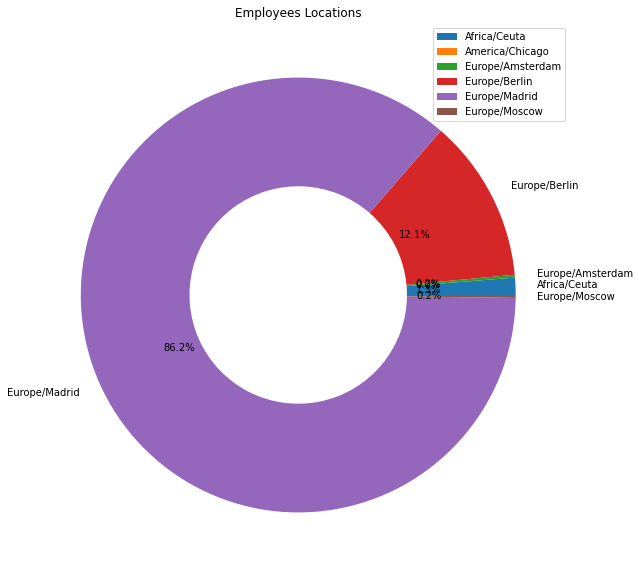

In [10]:
employee_details.groupby('timezone').\
    aggregate({'lastParticipationDate':'count'}).\
    plot.pie(y='lastParticipationDate', figsize=(10, 10), 
             autopct='%1.1f%%', # to add the percentages text
             wedgeprops=dict(width=.5)
            )
plt.ylabel("")
plt.title('Employees Locations')
plt.show()

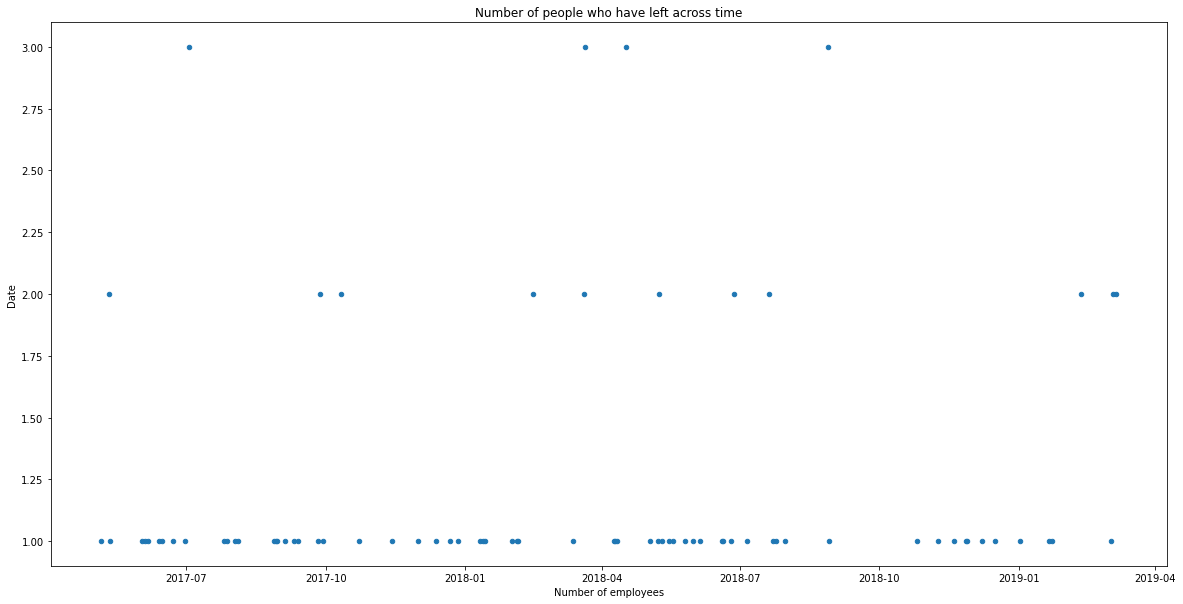

In [11]:
f, ax = plt.subplots(1, figsize = (20,10))

employee_details.loc[employee_details.lastParticipationDate.__ne__(None)].\
    loc[employee_details.stillExists == 0].\
    groupby('lastParticipationDate').aggregate({'stillExists':'count'}).reset_index().\
    plot(x = 'lastParticipationDate', y = 'stillExists', kind = 'scatter', ax=ax)

plt.title('Number of people who have left across time')
plt.xlabel('Number of employees')
plt.ylabel('Date')
plt.show()

## Votes
The next dataset of interest is the **votes dataset**. A listing of all votes registered on Happyforce to the question "How are you today?" from the employees on the dataset. All employees do not participate in this survey, but quite a lot of them do regularly.  

In [19]:
votes = pd.read_csv("votes.csv")
votes['voteDate'] = pd.to_datetime(votes['voteDate'])
votes = votes.sort_values(['employee', 'voteDate'])
votes

,employee,companyAlias,voteDate,vote
17862,13L,C1,2017-09-26 02:09:00,2
18093,13L,C1,2017-09-27 02:09:00,3
18406,13L,C1,2017-09-29 02:09:00,3
18562,13L,C1,2017-09-30 02:09:00,4
18635,13L,C1,2017-10-01 02:10:00,3
...,...,...,...,...
90055,zyx,C1,2018-12-15 01:12:00,3
90797,zyx,C1,2018-12-19 01:12:00,2
91235,zyx,C1,2018-12-21 01:12:00,2
91983,zyx,C1,2018-12-26 01:12:00,3


In [20]:
votes.describe(include='all', datetime_is_numeric=True)

,employee,companyAlias,voteDate,vote
count,106834,106834,106834,106834.000000
unique,472,1,NaN,NaN
top,xE4,C1,NaN,NaN
freq,671,106834,NaN,NaN
mean,NaN,NaN,2018-05-06 22:41:28.348840192,2.849580
min,NaN,NaN,2017-05-03 02:05:00,1.000000
25%,NaN,NaN,2017-11-27 01:11:00,2.000000
50%,NaN,NaN,2018-05-21 02:05:00,3.000000
75%,NaN,NaN,2018-10-19 02:10:00,4.000000
max,NaN,NaN,2019-03-11 01:03:00,4.000000


### EDA
We can see that the votes vary between 1 to 4, with averae being 2.89. This survey has data from 3-5-2017 to 11-3-2019. This survey was taken by 472 employees. While the data has details from 3-5-2017, there would be employees who joined after the survey has already started. Identifying them will help us to look for patterns over time for new employees. We are considering any employee that has the first vote 100 days after the inception (3-5-2017) as a new employee.  

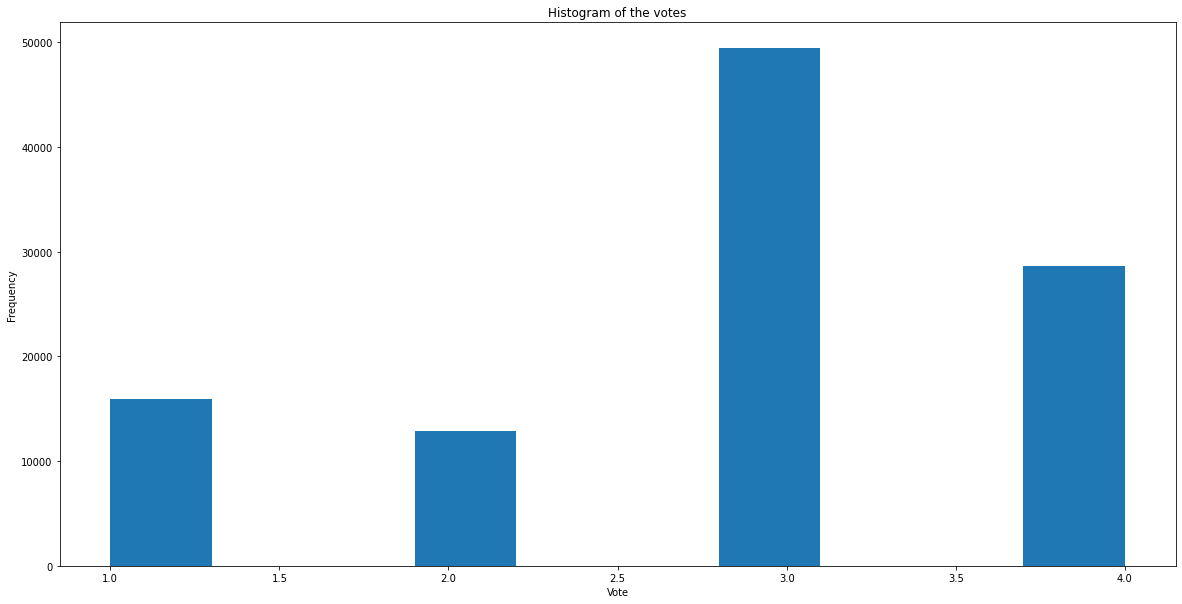

In [21]:
f, ax = plt.subplots(1, figsize = (20,10))
votes.vote.hist(grid = False, ax = ax)
plt.title('Histogram of the votes')
plt.xlabel('Vote')
plt.ylabel('Frequency')
plt.show()

### Feature engineering
We can observe that the default vote is 3, with more happy employees using 4 and less happy employees using 2 or 3. For the modelling, we want to create features which take only the data before the observation into account, and it is useful to have running means to capture the default charectersticks of the employee, and also to capture the latest 2 votes to capture if there has been any change from the normal recently. The columns after feature engineering are:  
1. (existing column) vote: what the employee voted (1 to 4, representing being very Bad, Bad, Good, Very Good)  
2. new_employee: We add a new parameter called "new employee" - we will label someone as a newer employee if their first vote has been more than 100 days (~3 months) since the software began collecting data  
3. min_date: the date of the first recorded vote by an employee  
4. no_of_days_since_first_vote: we use this as proxy for tenure in the company  
5. no_of_votes_till_date: use this as proxy for engagement with the company  
6. perc_days_voted: another way to look at engagement with the company (adjusted for tenure)  
7. avg_vote_till_date: proxy for job satisfaction (the higher the better)  
8. avg_vote: same as above, but taking all votes (not just to date)  
9. last_2_votes_avg: proxy for most recent sentiment at their job

In [22]:
# Feature engineering on the votes dataset
votes['min_date'] = votes.groupby('employee')['voteDate'].transform(min)

# new employee is 100 day since inception of the software
votes['new_employee'] = (votes.min_date >= '13-06-2017 00:00:00').astype(int) 

# Getting the difference in days since first vote in days
votes['no_of_days_since_first_vote'] = ((votes.voteDate - votes.min_date)/np.timedelta64(1, 'D')).astype(int)+1

# Calculating the cumulative number of votes till date (only considering the past: this step should be done after order by)
votes['no_of_votes_till_date'] = votes.groupby('employee')['voteDate'].transform('cumcount')+1

# calculating the percentage of days that the employee has voted till date
votes['perc_days_voted'] = votes['no_of_votes_till_date']/votes['no_of_days_since_first_vote']

# average of the vote till date by the employee
votes['avg_vote_till_date'] = votes.groupby('employee')['vote'].transform('cumsum')/(votes['no_of_votes_till_date'])

# Average vote in general of the employee
votes['avg_vote'] = votes.groupby('employee')['vote'].transform(np.mean)

# The average of the last two votes (The last two votes might redict the probability of taking a leave now)
votes['last_2_votes_avg'] = list(votes.groupby('employee').rolling(2, min_periods=1)['vote'].apply(np.mean))
votes['date'] = votes.voteDate.dt.date.astype('datetime64[ns]')

In the scatterplot below we can see an interesting trend / relationship between votes (1 to 4) and employee tenure. We can see the newer employees (green dots) are overall more satisfied than older employees (red dots). We can also see that over time, more tenured employees show a concerning downward trend in satisfaction. This could be one of the drivers for churn or increased absences.

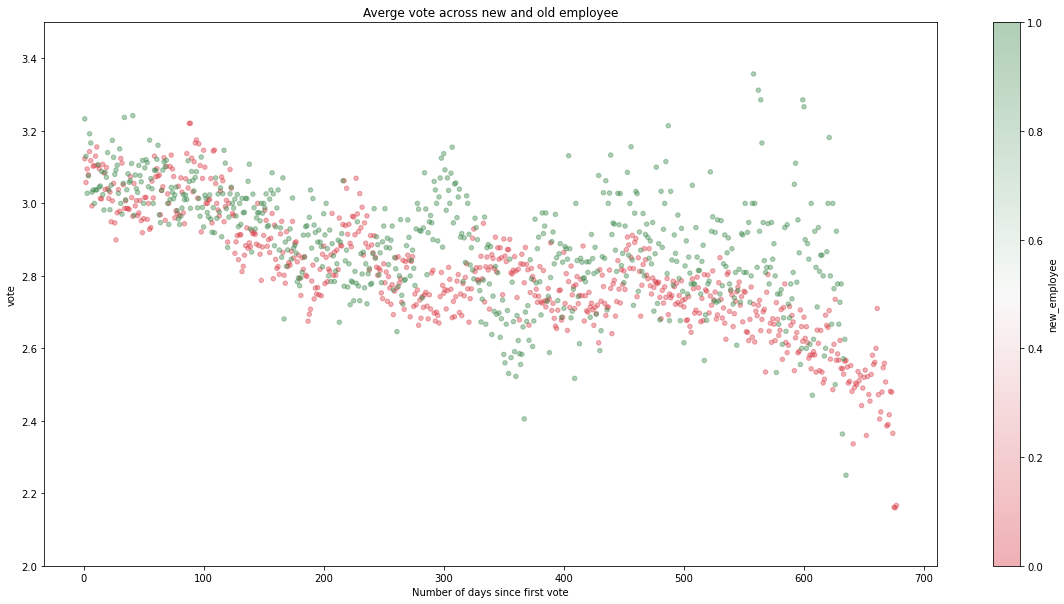

In [23]:
fs, axs = plt.subplots(1, figsize=(20,10))
votes.groupby(['new_employee', 'no_of_days_since_first_vote']).agg({'vote':'mean'}).reset_index().\
    plot.scatter(x='no_of_days_since_first_vote', y = 'vote', c='new_employee', alpha = 0.4, 
                cmap = sns.diverging_palette(10, 133,as_cmap=True), ax = axs)#, vmin = 2.0, vmax=3.5)
axs.set_ylim([2, 3.5])
plt.title('Averge vote across new and old employee')
plt.xlabel('Number of days since first vote')
plt.show()

We can see there is some seasonality in votes. This could be related to specific busy periods at the company, or relate to specific incidents that have occured. It can also be a matter of seasons (employees tend to be happier before or around holiday seasons, for example).

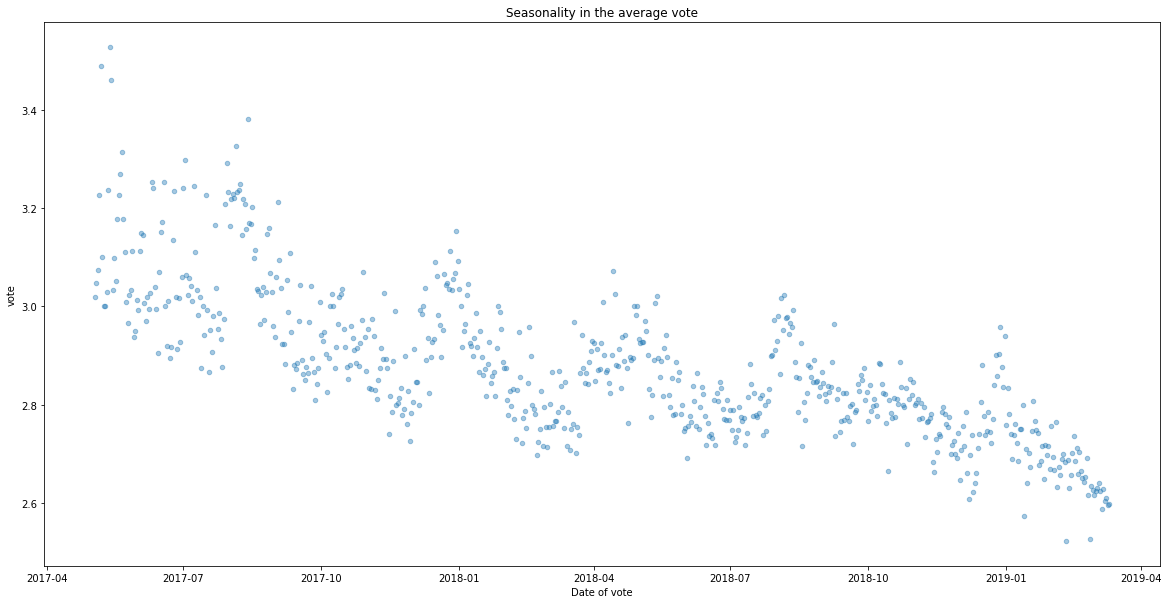

In [24]:
fs, axs = plt.subplots(1, figsize=(20,10))
votes.groupby(['voteDate']).agg({'vote':'mean'}).reset_index().\
    plot.scatter(x='voteDate', y = 'vote', alpha = 0.4, ax = axs)
plt.title('Seasonality in the average vote')
plt.xlabel('Date of vote')
plt.show()

In [25]:
# joining the votes table with employee details to add the details of the employee
votes = votes.merge(employee_details, how = 'left', on = 'employee')

Does the average vote decrease just before a person quits the organisation? We can identify this by filtering for the employees who have already quit, and look at the average votes since the last day. We identify that the votes are actually pretty consistant with a mean around 2.8 before the notice period while it decreases in the notice period(of presumably 60 days).

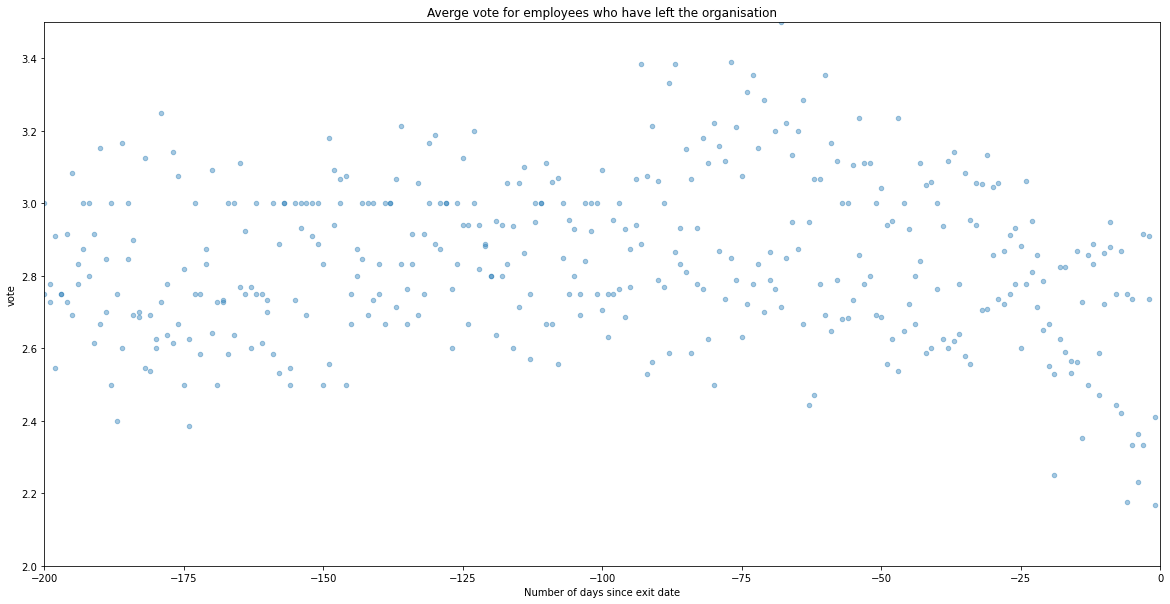

In [26]:
people_who_left = votes[votes.stillExists == 0].copy()
people_who_left.loc[:,'no_of_days_since_exit'] = ((people_who_left.voteDate - people_who_left.deletedOn)/np.timedelta64(1, 'D')).astype(int)-1

fs, axs = plt.subplots(1, figsize=(20,10))
people_who_left.groupby(['new_employee', 'no_of_days_since_exit']).agg({'vote':'mean'}).reset_index().\
    plot.scatter(x='no_of_days_since_exit', y = 'vote', alpha = 0.4, ax = axs)
axs.set_xlim([-200, 0])
axs.set_ylim([2, 3.5])
plt.title('Averge vote for employees who have left the organisation')
plt.xlabel('Number of days since exit date')
plt.show()

As we have employees across 5 timezones, the average votes across timezones are also shown. We can see distinct seasonality patterns across different geographies. Some gerographies have low variation as they have very few employees.  

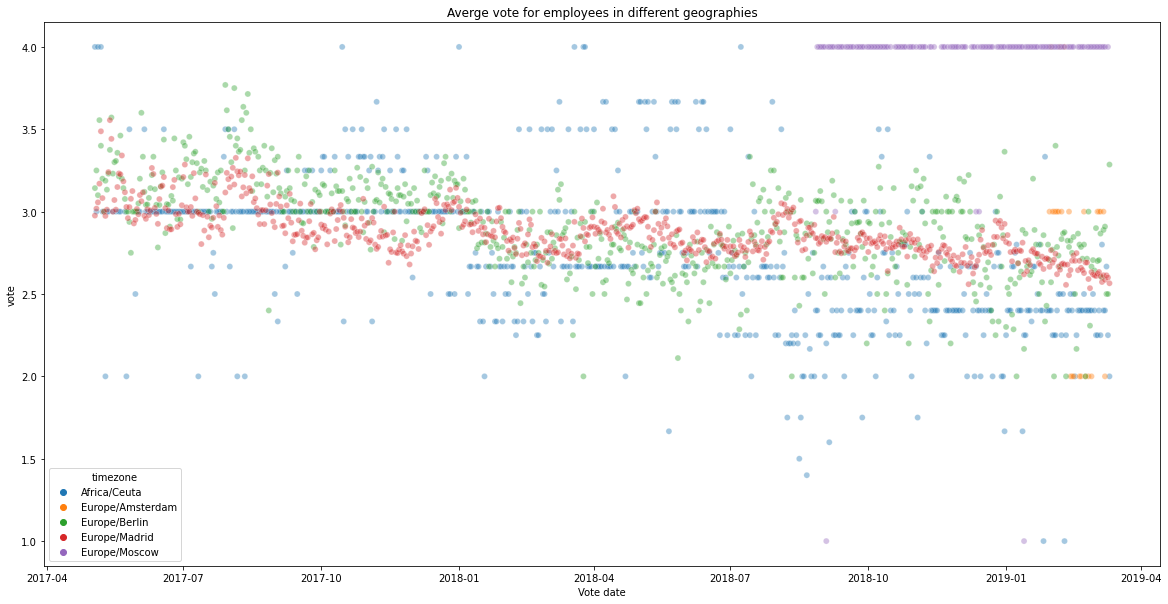

In [27]:
fs, axs = plt.subplots(1, figsize=(20,10))
sns.scatterplot(data = votes.groupby(['timezone', 'voteDate']).agg({'vote':'mean'}).reset_index(), 
                x='voteDate', y = 'vote', hue = 'timezone', alpha = 0.4, ax = axs)
plt.title('Averge vote for employees in different geographies')
plt.xlabel('Vote date')
plt.show()

## Feedback dataset
The next dataset of interest is the **comments feedback** dataset. This contains all the different comments given by employees, and the number of likes and dislikes on each of the comment. Likes, Dislikes and comments are various proxy;s for engagement.  

In [28]:
feedback = pd.read_csv("comments_by_employees_in_anonymous_forum.csv")
feedback

,employee,companyAlias,commentId,commentLength,likes,dislikes,commentDate,feedbackType
0,aKP,C1,5909b33da2ede4000473da6f,17,9,0,2017-05-03 12:05,OTHER
1,dNx,C1,5909b6aca2ede4000473da72,25,12,0,2017-05-03 12:05,OTHER
2,ONv,C1,5909c2dea2ede4000473db8c,58,33,5,2017-05-03 13:05,OTHER
3,e9M,C1,5909d32ea2ede4000473db97,56,11,4,2017-05-03 14:05,OTHER
4,RWM,C1,5909f227a2ede4000473dcbe,105,18,0,2017-05-03 17:05,OTHER
...,...,...,...,...,...,...,...,...
5067,7o1,C1,5c7108e8434c4500041722b0,28,0,0,2019-02-23 09:02,OTHER
5068,N3,C1,5c71519ca9f66e00042896f6,14,0,0,2019-02-23 14:02,OTHER
5069,DNY,C1,5c73b11e50b72e0004cab283,63,0,0,2019-02-25 10:02,OTHER
5070,72j,C1,5c744971e29c7b0004391da3,44,0,0,2019-02-25 21:02,OTHER


In [29]:
feedback.describe(include='all', datetime_is_numeric=True)

,employee,companyAlias,commentId,commentLength,likes,dislikes,commentDate,feedbackType
count,5072,5072,5072,5072.000000,5072.000000,5072.00000,5072,5072
unique,305,1,5072,NaN,NaN,NaN,3580,5
top,4ov,C1,595f9176719d61000484a93d,NaN,NaN,NaN,2018-09-10 09:09,OTHER
freq,373,5072,1,NaN,NaN,NaN,26,3188
mean,NaN,NaN,NaN,168.518336,13.605875,4.89097,NaN,NaN
std,NaN,NaN,NaN,193.802568,15.280530,6.62993,NaN,NaN
min,NaN,NaN,NaN,1.000000,0.000000,0.00000,NaN,NaN
25%,NaN,NaN,NaN,48.000000,2.000000,0.00000,NaN,NaN
50%,NaN,NaN,NaN,111.000000,9.000000,3.00000,NaN,NaN
75%,NaN,NaN,NaN,223.000000,20.000000,7.00000,NaN,NaN


### EDA
We can observe that as the number of interactions becomes larger, the overall trend goes either towards likes or dislikes. We can also observe that comments above 80 interactions are usually highly liked.  

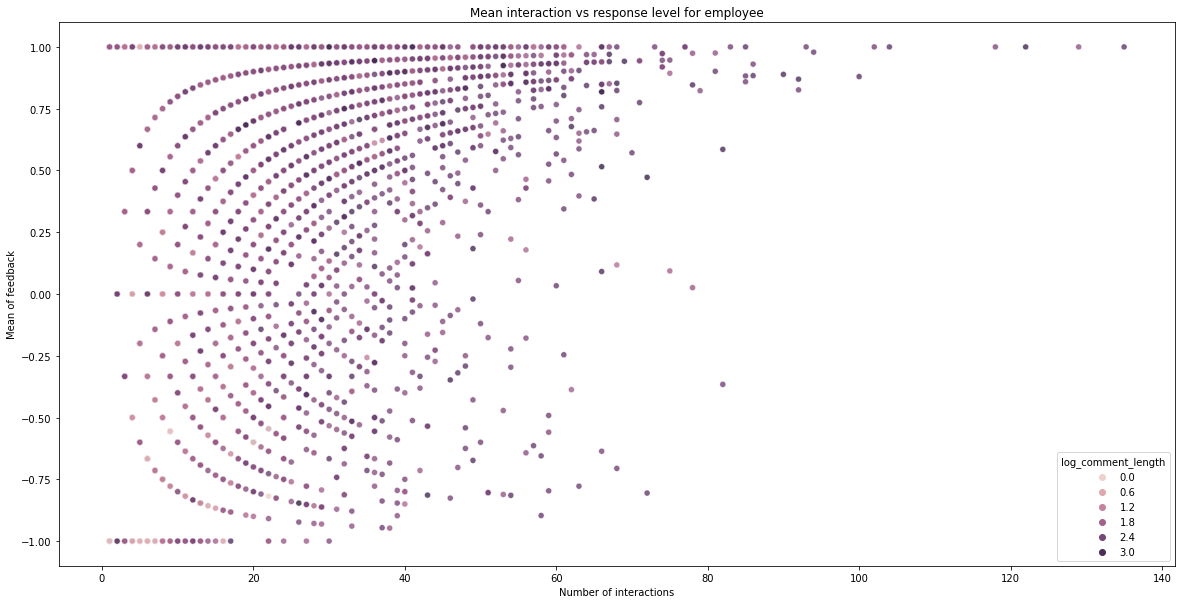

In [30]:
feedback['log_comment_length'] = np.log10(feedback.commentLength)
feedback['total_interactions'] = feedback.likes+feedback.dislikes
feedback['mean_feedback'] = (feedback.likes-feedback.dislikes)/feedback.total_interactions

fs, axs = plt.subplots(1, figsize=(20,10))
sns.scatterplot(data = feedback, 
                x='total_interactions', y = 'mean_feedback', hue = 'log_comment_length', alpha = 0.8, ax = axs)
plt.title('Mean interaction vs response level for employee')
plt.xlabel('Number of interactions')
plt.ylabel('Mean of feedback')
plt.show()

We can see that we have five types of comments

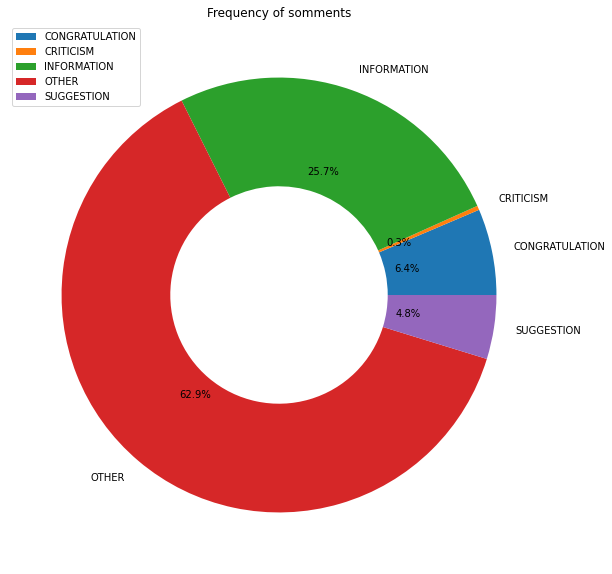

In [31]:
feedback.feedbackType.unique()
feedback.groupby('feedbackType').\
    aggregate({'commentId':'count'}).\
    plot.pie(y='commentId', figsize=(10, 10), 
             autopct='%1.1f%%', # to add the percentages text
             wedgeprops=dict(width=.5)
            )
plt.ylabel("")
plt.title('Frequency of somments')
plt.show()

Similarly we can see a trend between different comment types, with congratulations receiving more likes than dislikes, while suggestions and information having similar distibutions. We can also see how the number of likes are skewed.

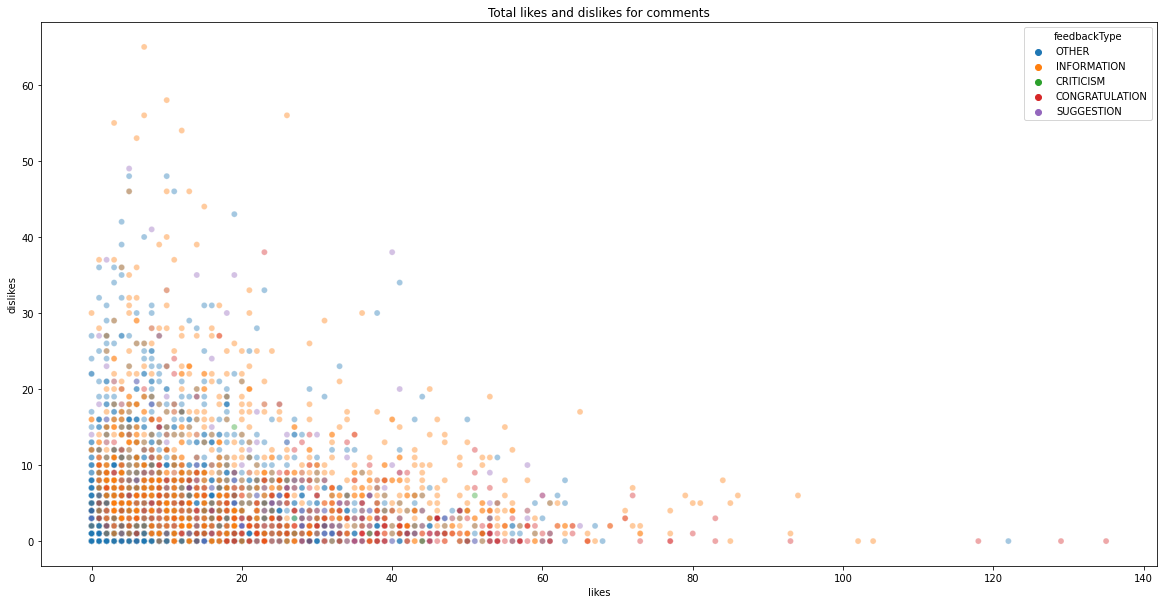

In [32]:
fs, axs = plt.subplots(1, figsize=(20,10))
sns.scatterplot(data = feedback, 
                x='likes', y = 'dislikes', hue = 'feedbackType', alpha = 0.4, ax = axs)
plt.title('Total likes and dislikes for comments')
plt.show()

In [33]:
feedback.groupby('feedbackType').aggregate({'likes':'mean', 'dislikes':'mean'})

,likes,dislikes
feedbackType,,
CONGRATULATION,30.941538,3.824615
CRITICISM,11.125000,1.562500
INFORMATION,18.751152,7.657450
OTHER,9.325282,3.705144
SUGGESTION,19.219917,7.290456


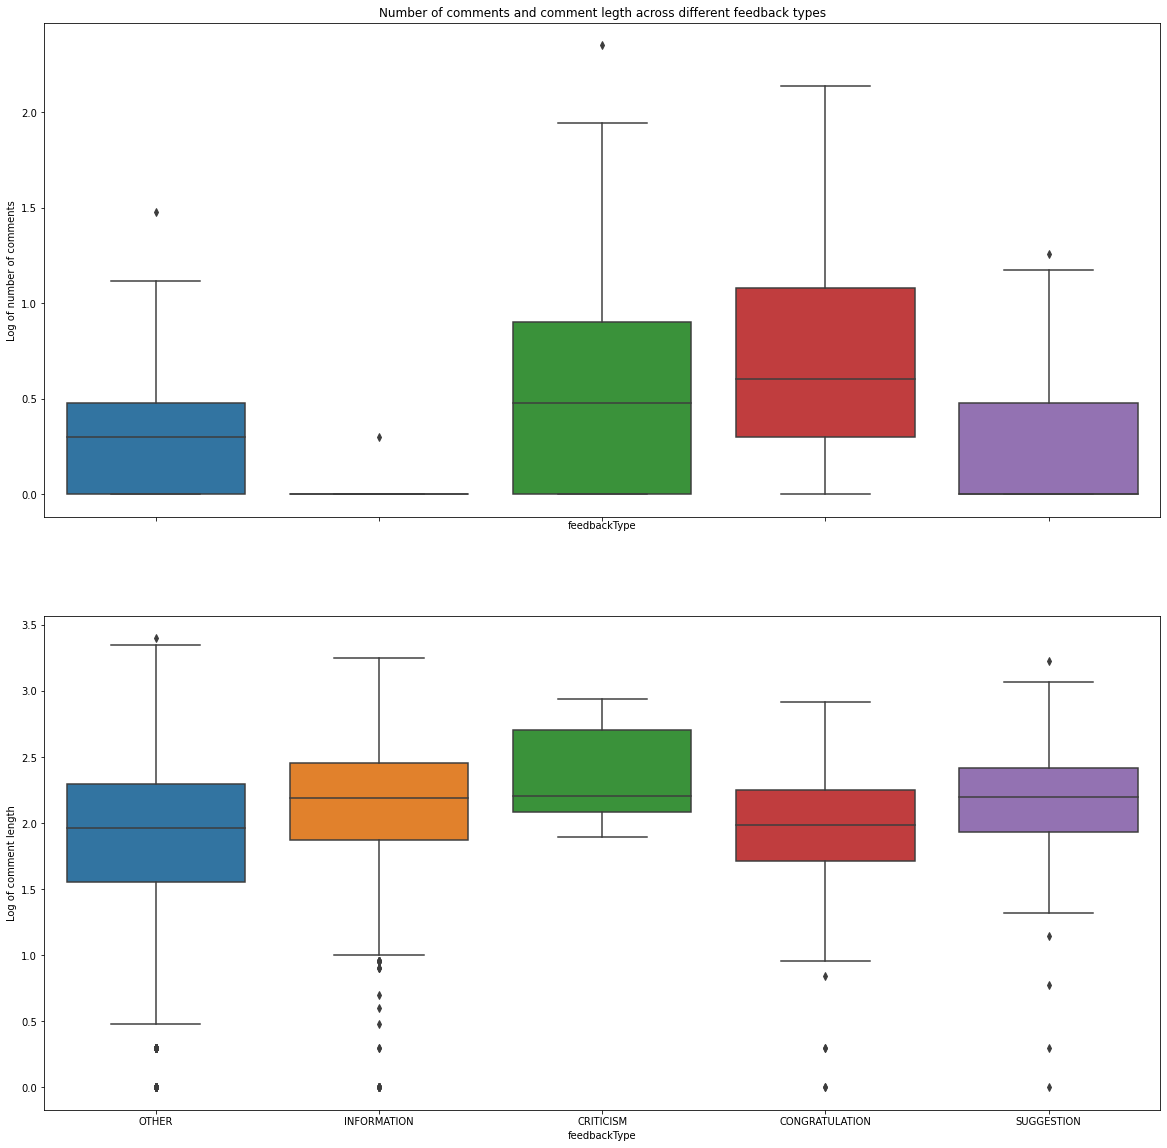

In [34]:
f, ax = plt.subplots(2, figsize = (20,20), sharex = True)

sns.boxplot(data = feedback.groupby(['feedbackType', 'employee'])['commentId'].count().reset_index().assign(
        log_count_comments = lambda df: np.log10(df.commentId)
    ), 
            x = 'feedbackType', y = 'log_count_comments', ax = ax[0])

sns.boxplot(data = feedback, x = 'feedbackType', y = 'log_comment_length', ax = ax[1])

ax[0].set_ylabel('Log of number of comments')
ax[1].set_ylabel('Log of comment length')
ax[0].set_title('Number of comments and comment legth across different feedback types')
plt.show()

### Feature engineering

In [35]:
# feature engineering on the feedback dataset
feedback['commentDate'] = pd.to_datetime(feedback['commentDate'])

# sort by date in ascending to do cumulative sum and rolling calculations
feedback = feedback.sort_values(['employee', 'commentDate'])

# Count the likes and dislikes till the date given
feedback['likes_till_date']= feedback.groupby('employee')['likes'].transform('cumsum')
feedback['dislikes_till_date']= feedback.groupby('employee')['dislikes'].transform('cumsum')
feedback['comments_till_date']= feedback.groupby('employee')['commentId'].transform('cumcount')

# Rolling two likes and dislikes, indicating the last two likes and dislikes
feedback['last_2_likes'] = list(feedback.groupby('employee').rolling(2, min_periods=1)['likes'].apply(sum))
feedback['last_2_dislikes'] = list(feedback.groupby('employee').rolling(2, min_periods=1)['dislikes'].apply(sum))
feedback['date'] = feedback.commentDate.dt.date.astype('datetime64[ns]')
feedback

,employee,companyAlias,commentId,commentLength,likes,dislikes,commentDate,feedbackType,log_comment_length,total_interactions,mean_feedback,likes_till_date,dislikes_till_date,comments_till_date,last_2_likes,last_2_dislikes,date
4373,19Q,C1,5959ec954040610004272a21,11,0,0,2017-07-03 09:07:00,OTHER,1.041393,0,NaN,0,0,0,0.0,0.0,2017-07-03
970,19Q,C1,5970e1483da0e10004b17a27,64,3,4,2017-07-20 18:07:00,OTHER,1.806180,7,-0.142857,3,4,1,3.0,4.0,2017-07-20
1903,19Q,C1,5a36f82b26c0110004c55d90,57,17,6,2017-12-18 00:12:00,OTHER,1.755875,23,0.478261,20,10,2,20.0,10.0,2017-12-18
1949,19Q,C1,5a40e7d3de51cb00042dfda4,31,5,0,2017-12-25 12:12:00,OTHER,1.491362,5,1.000000,25,10,3,22.0,6.0,2017-12-25
1972,19Q,C1,5a4a8275eb84e0000492659f,11,8,0,2018-01-01 19:01:00,OTHER,1.041393,8,1.000000,33,10,4,13.0,0.0,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740,zRx,C1,5be95746ed7ae70004b83417,11,0,0,2018-11-12 11:11:00,OTHER,1.041393,0,NaN,0,0,0,0.0,0.0,2018-11-12
4746,zRx,C1,5be95746ed7ae70004b83415,26,0,0,2018-11-12 11:11:00,OTHER,1.414973,0,NaN,0,0,1,0.0,0.0,2018-11-12
4758,zRx,C1,5be95747ed7ae70004b83419,33,0,0,2018-11-12 11:11:00,OTHER,1.518514,0,NaN,0,0,2,0.0,0.0,2018-11-12
4764,zRx,C1,5be95746ed7ae70004b83418,11,0,0,2018-11-12 11:11:00,OTHER,1.041393,0,NaN,0,0,3,0.0,0.0,2018-11-12


## Merging all the datasets  
Now we combine employee abseteeism data with votes and comments datasets. We have the following issues:
1. The absenteeism dataset is a subset of the data and does not cover all employees and months    
2. Not all employees have voted and even those who have voted have voted infrequently  
3. Not all employees have commented and even those who have posted a comment posted infrequently  

So we have the following assumptions:  
1. We are working with the data only for the employees that exist in the absenteeism dataset  
2. We are assuming that the last vote of the employee talks about the how the employee today  
3. We are also assuming that the last comment and the likes and dislikes have an effect on the employee  

With these assumptions, we combine the datasets.

In [36]:
# Creating a dataframe containing the time from the start to the end of voting period
time_dataframe = pd.DataFrame({'date':pd.date_range(min(votes['voteDate']).date(), max(votes['voteDate']).date())})
time_dataframe['tmp'] = 1

# Creating a dataframe with all employees in the absenteeism dataset
complete_df = pd.DataFrame({'employee':df.employee.unique()})
complete_df['tmp'] = 1

# Creating a dataset that contains the combinations of all days for all employees
complete_df = pd.merge(complete_df, time_dataframe, on=['tmp']).drop('tmp', axis = 1)

# Joining the feedback (comments) given by the employees
complete_df = pd.merge(complete_df, feedback, how = 'left', on=['date', 'employee'])
complete_df = complete_df[['employee', 'date', 'likes', 'dislikes', 'feedbackType', 'likes_till_date', 'dislikes_till_date', 'last_2_likes', 'last_2_dislikes', 'commentDate']]

# Filling the last available feedback data the days when there was no feedback data for an employee.
complete_df[['date', 'likes', 'dislikes', 'feedbackType', 'likes_till_date', 'dislikes_till_date', 'last_2_likes', 'last_2_dislikes', 'commentDate']] = \
    complete_df.groupby('employee').fillna(method='ffill')

# Creating new features
complete_df['days_since_last_comment'] = (complete_df.date-complete_df.commentDate)
complete_df['days_since_last_comment'] = (complete_df['days_since_last_comment'].fillna(pd.Timedelta(seconds=0))/np.timedelta64(1, 'D')).astype(int)

# Assuming that for the employees that hae not commented (yet) the feedback is 0.
complete_df = \
    complete_df[['employee', 'date', 'likes', 'dislikes', 'feedbackType', 'likes_till_date', 'dislikes_till_date', 'last_2_likes', 'last_2_dislikes', 'days_since_last_comment']].\
    fillna(0)

# Joining the votes dataset fr every eployee-date
complete_df = pd.merge(complete_df, votes, how = 'left', on=['date', 'employee'])

# Filling the last available votes data the days when there was no vote for an employee.
complete_df[[ 'no_of_votes_till_date','perc_days_voted', 'deletedOn', 'new_employee', 'min_date', 'stillExists', 'vote',
             'avg_vote_till_date', 'avg_vote','last_2_votes_avg', 'voteDate', 'timezone']] = \
    complete_df.groupby('employee')[['no_of_votes_till_date','perc_days_voted', 'deletedOn', 'new_employee', 'min_date', 'stillExists', 'vote',
                                     'avg_vote_till_date', 'avg_vote','last_2_votes_avg', 'voteDate', 'timezone']].\
    fillna(method='ffill')

# Remove the data before the employee joined
complete_df = complete_df[complete_df.avg_vote >= 0]

# Remove data after employee left
complete_df = complete_df[(complete_df.stillExists == 1) | ((complete_df.stillExists == 0) & (complete_df.date <= complete_df.deletedOn))]

# Recomputing no_of_days_since_first_vote
complete_df.no_of_days_since_first_vote = ((complete_df.date - complete_df.min_date)/np.timedelta64(1, 'D')).astype(int)+1

# Adding new features
# assuming a 60 day notice period
# 60 days before the employee leaves are recorded
complete_df.deletedOn = complete_df.deletedOn.fillna(pd.to_datetime(date.today()))
complete_df['countdown_to_last_day'] = ((complete_df.date - complete_df.deletedOn)/np.timedelta64(1, 'D')).astype(int)+1
complete_df.loc[complete_df.countdown_to_last_day < -15, 'countdown_to_last_day'] = 999

# computing days since last vote
complete_df['days_since_last_vote'] = (complete_df.date-complete_df.voteDate)
complete_df['days_since_last_vote'] = (complete_df['days_since_last_vote'].fillna(pd.Timedelta(seconds=0))/np.timedelta64(1, 'D')).astype(int)

# Imputing still exists column
complete_df[['timezone', 'stillExists']] = complete_df.groupby('employee')[['timezone', 'stillExists']].fillna(method = 'bfill')

# Selecting the features used in the model
complete_df = complete_df[
    ['employee', 'date', 'likes', 'dislikes', 'feedbackType', 
     'likes_till_date', 'dislikes_till_date', 'last_2_likes', 'last_2_dislikes', 
     'days_since_last_comment', 'vote', 'timezone', 'stillExists',
       'no_of_days_since_first_vote', 'no_of_votes_till_date',
       'perc_days_voted', 'avg_vote_till_date', 'avg_vote', 'last_2_votes_avg',
       'days_since_last_vote', 'new_employee', 'countdown_to_last_day']].fillna(0)


In [37]:
pd.options.display.max_columns = None

# Combining the leaves dataset
data = pd.merge(complete_df, leave_df, how = 'left', on=['date', 'employee'])
data.on_leave = data.on_leave.fillna(0)

# Creating new columns
data.no_leaves_till_date = data.no_leaves_till_date.fillna(method = 'bfill').fillna(method = 'ffill')

# Get the number of days the person was on leave in the last two days
def get_rolling_sum(grp, freq, col):
    return(grp.rolling(freq, on='date')[col].sum())
data = data.sort_values(['employee', 'date'])
data['last_2_days_leaves']  = data.groupby('employee', as_index = False, group_keys=False).\
    apply(get_rolling_sum, '2D', 'on_leave') # 2d for 2 days

# Get the leave status of the previous day
data['previous_day_leave'] = data.groupby('employee')['on_leave'].shift().fillna(0)

# Renaming columns to more suitable ones
data.rename(columns={"likes": "last_likes", "dislikes": "last_dislikes", "feedback_type":"last_feedback_type",
                    "vote":"last_vote", "new_employee":"employee_joined_after_jun17"}, inplace = True)

The correlation matrix for all the columns is

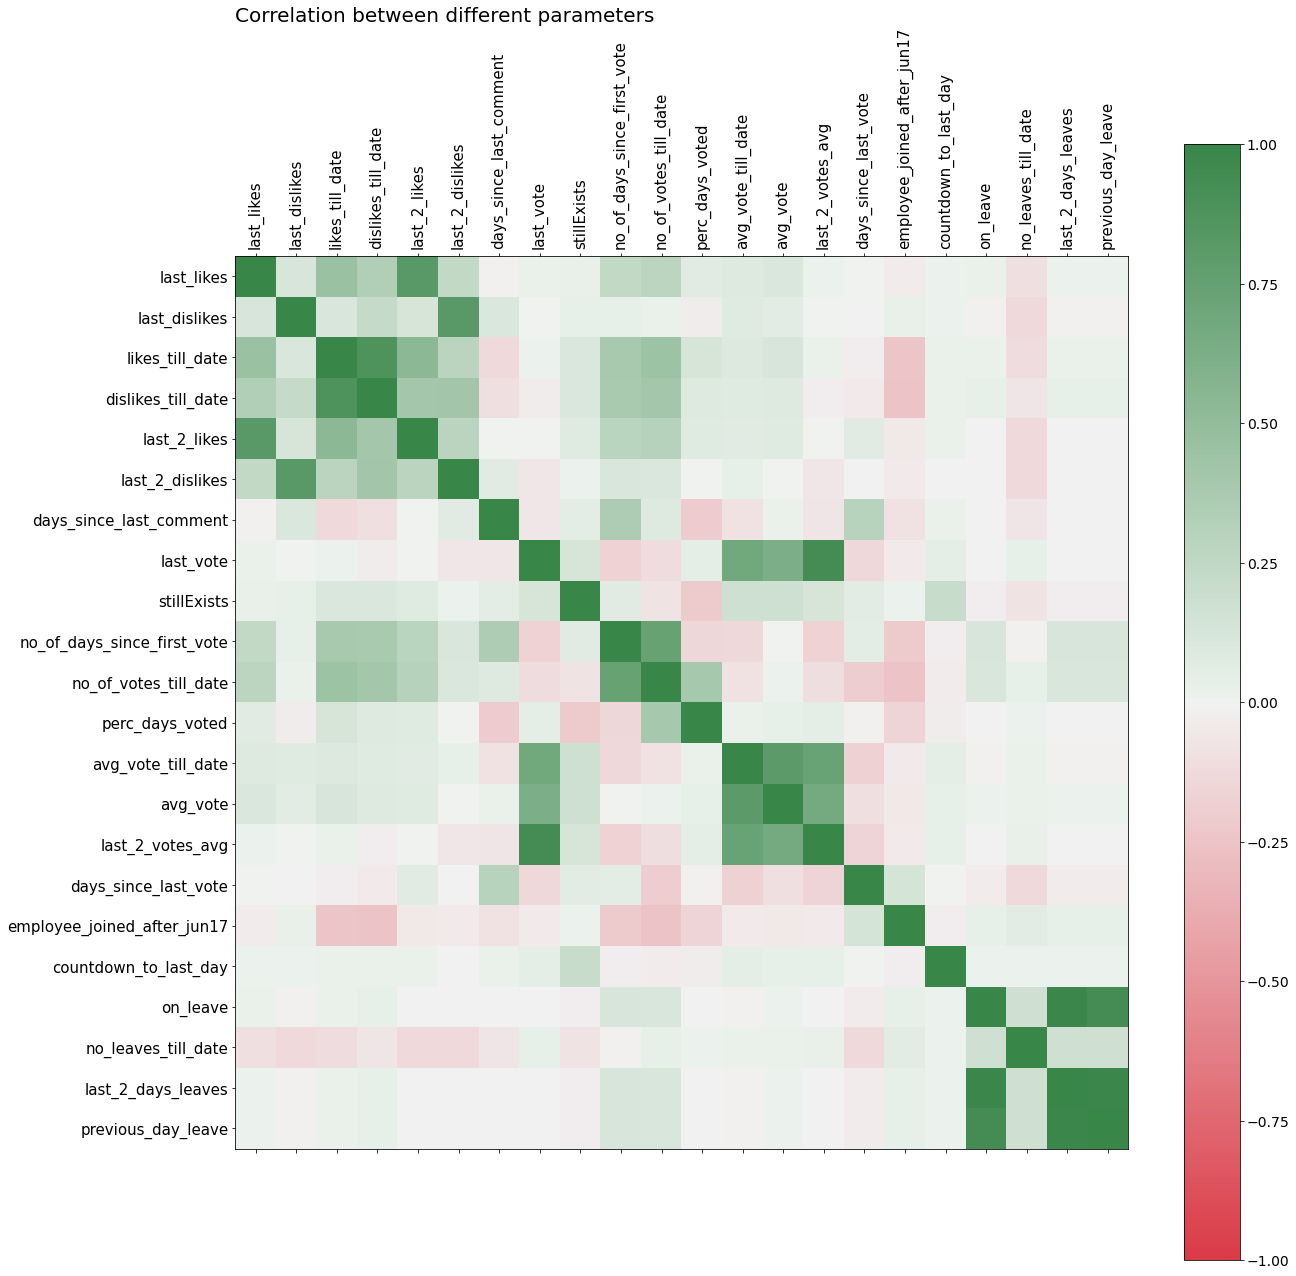

In [38]:
red_green_cmap = sns.diverging_palette(10, 133,as_cmap=True)

f = plt.figure(figsize=(20, 20))
plt.matshow(data.corr(), fignum = f, cmap = red_green_cmap, vmin=-1, vmax=1)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), 
           data.select_dtypes(['number']).columns, rotation=90, fontsize = 15)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), 
           data.select_dtypes(['number']).columns, rotation=0, fontsize = 15)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Correlation between different parameters", fontsize=20,loc='left')
plt.show()

The distributions across all the columns are

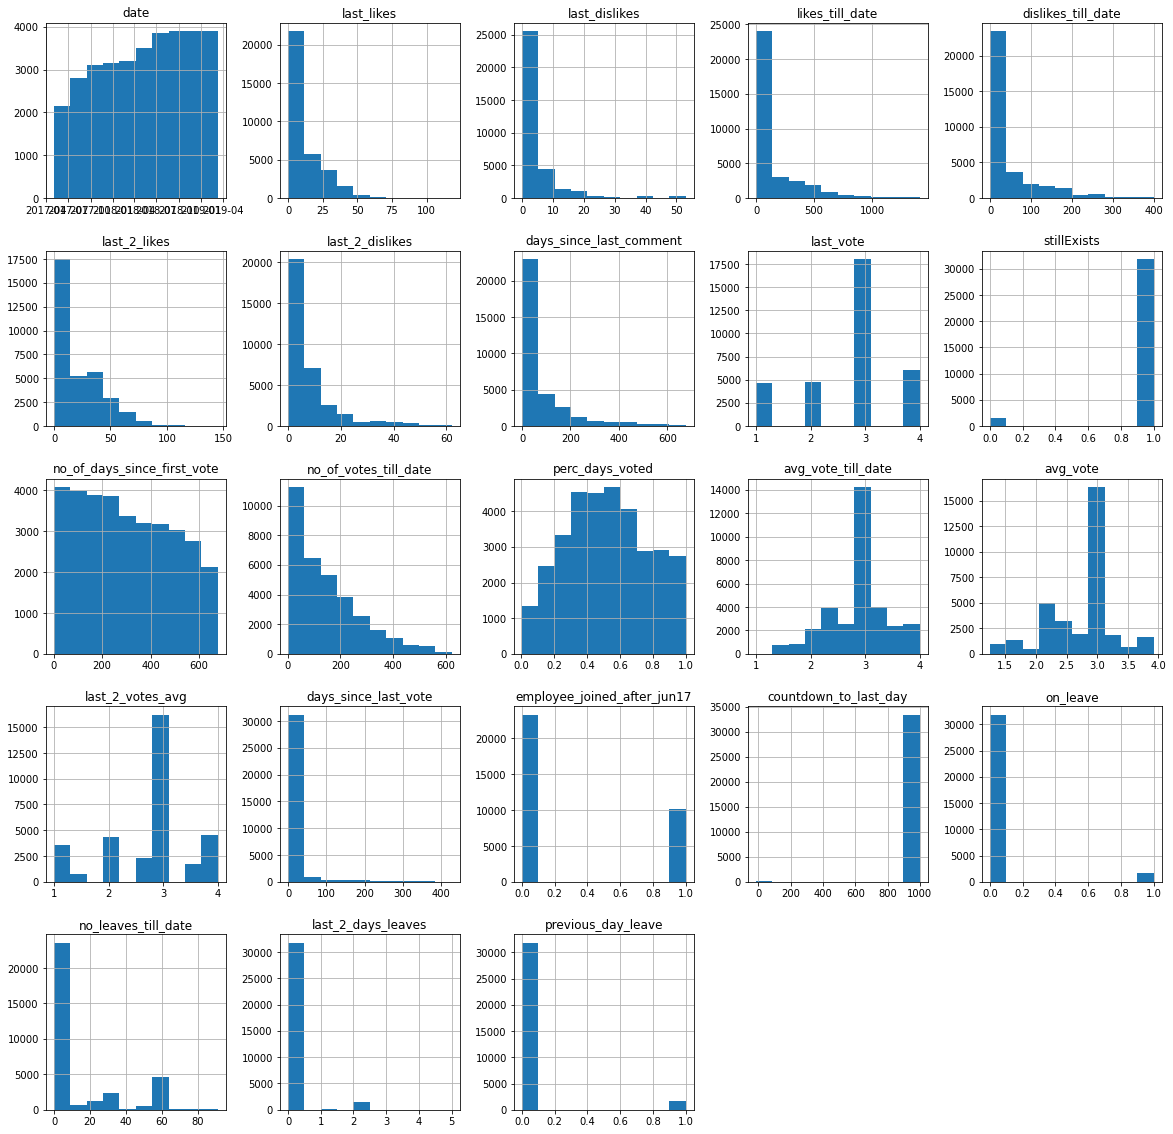

In [39]:
_ = data.hist(figsize = (20,20))

## Date as a predictor variable
We have previously seen that most leaves are applied either on the first of the month or on the last of the month. This indicates that the day of the week, month and other date characteristics are also significant.

In [50]:
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
month_name = [None, 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data['weekday'] = data.date.dt.weekday.apply(lambda x:day_name[x])
data['month'] = data.date.dt.month.apply(lambda x:month_name[x])
data['week'] = data.date.dt.day % 7 # Which week in the month
data

,employee,date,last_likes,last_dislikes,feedbackType,likes_till_date,dislikes_till_date,last_2_likes,last_2_dislikes,days_since_last_comment,last_vote,timezone,stillExists,no_of_days_since_first_vote,no_of_votes_till_date,perc_days_voted,avg_vote_till_date,avg_vote,last_2_votes_avg,days_since_last_vote,employee_joined_after_jun17,countdown_to_last_day,reason,on_leave,no_leaves_till_date,last_2_days_leaves,previous_day_leave,weekday,month,day,week
23729,17r,2018-05-29,0.0,0.0,0,0.0,0.0,0.0,0.0,0,3.0,Europe/Madrid,1.0,1,1.0,1.000000,3.000000,2.121212,3.0,0,1.0,999,NaN,0.0,0.0,0.0,0.0,Tuesday,May,29,1
23730,17r,2018-05-30,0.0,0.0,0,0.0,0.0,0.0,0.0,0,3.0,Europe/Madrid,1.0,1,1.0,1.000000,3.000000,2.121212,3.0,0,1.0,999,NaN,0.0,0.0,0.0,0.0,Wednesday,May,30,2
23731,17r,2018-05-31,0.0,0.0,0,0.0,0.0,0.0,0.0,0,3.0,Europe/Madrid,1.0,2,1.0,1.000000,3.000000,2.121212,3.0,1,1.0,999,NaN,0.0,0.0,0.0,0.0,Thursday,May,31,3
23732,17r,2018-06-01,0.0,0.0,0,0.0,0.0,0.0,0.0,0,3.0,Europe/Madrid,1.0,3,2.0,0.500000,3.000000,2.121212,3.0,0,1.0,999,NaN,0.0,0.0,0.0,0.0,Friday,Jun,1,1
23733,17r,2018-06-02,0.0,0.0,0,0.0,0.0,0.0,0.0,0,3.0,Europe/Madrid,1.0,4,2.0,0.500000,3.000000,2.121212,3.0,0,1.0,999,NaN,0.0,0.0,0.0,0.0,Saturday,Jun,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32232,zGB,2019-03-07,24.0,8.0,OTHER,24.0,8.0,24.0,8.0,299,3.0,Europe/Madrid,1.0,639,66.0,0.109272,3.015152,3.015152,3.0,34,0.0,999,NaN,0.0,0.0,0.0,0.0,Thursday,Mar,7,0
32233,zGB,2019-03-08,24.0,8.0,OTHER,24.0,8.0,24.0,8.0,300,3.0,Europe/Madrid,1.0,640,66.0,0.109272,3.015152,3.015152,3.0,35,0.0,999,NaN,0.0,0.0,0.0,0.0,Friday,Mar,8,1
32234,zGB,2019-03-09,24.0,8.0,OTHER,24.0,8.0,24.0,8.0,301,3.0,Europe/Madrid,1.0,641,66.0,0.109272,3.015152,3.015152,3.0,36,0.0,999,NaN,0.0,0.0,0.0,0.0,Saturday,Mar,9,2
32235,zGB,2019-03-10,24.0,8.0,OTHER,24.0,8.0,24.0,8.0,302,3.0,Europe/Madrid,1.0,642,66.0,0.109272,3.015152,3.015152,3.0,37,0.0,999,NaN,0.0,0.0,0.0,0.0,Sunday,Mar,10,3


The second part of the blog is [here]().  

## References
1. Notes, Wrokforce Analytics Live lecture, Imperial college London, Class 2020-22  
2. Kyburz J, Morelli D, Schaaf A, Villani F, Wheatley D:  *Predicting absenteeism*
3. Harsha A, Shaked A, Artem G, Tebogo M, Gokhan M:  *Predicting absenteeism*

In [51]:
data.to_csv('data_after_feature_engg.csv')